# We just consider the following classes

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import os
import numpy as np
import shutil
class COCO_Json_Builder():
    def __init__(self):
        self.images = []
        self.annotations = []
        self.categories = []
        
    def add_image(self, file_name, height, width, date_captured, _id, license=1):
        self.images.append( {
            "license":license, 
            "file_name": file_name, 
          "coco_url": "",
          "height": height,
          "width": width,
          "date_captured": date_captured, 
          "flickr_url": "",
          "id": _id
        } )
    
    def add_annotation(self, segmentation, area, iscrowd, image_id, bbox, category_id, _id):
        self.annotations.append( {
            "segmentation":segmentation, 
            "area": area, 
            "iscrowd": iscrowd, 
            "image_id": image_id, 
            "bbox": bbox, 
            "category_id":category_id, 
            "id":_id
        })
    
    def add_category(self, supercategory, _id, name):
        self.categories.append({
            "supercategory": supercategory, 
            "id":_id, 
            "name":name
        })
    
    def build_json(self, json_filename):
        f = open(json_filename, "w", encoding='utf-8')
        temp = {"images":self.images, "annotations":self.annotations, "categories":self.categories}
        json.dump(temp, f)
        self.images = []
        self.annotations =[]
        self.categories = []

In [4]:
COCO_Builder= COCO_Json_Builder()

# Copy images & jsons to one folder w/o thermal

In [5]:
dst = "C:/Users/david/Desktop/collated_data"
for root, dirs,files in os.walk("C:/Users/david/Desktop/data"):
    for file in files:
        type_image = file.split("_")[4]
        if type_image != "T":
            file_orig_path = os.path.join(root, file)
            shutil.copyfile(file_orig_path, dst+"/"+file)

# Merge jsons into one json

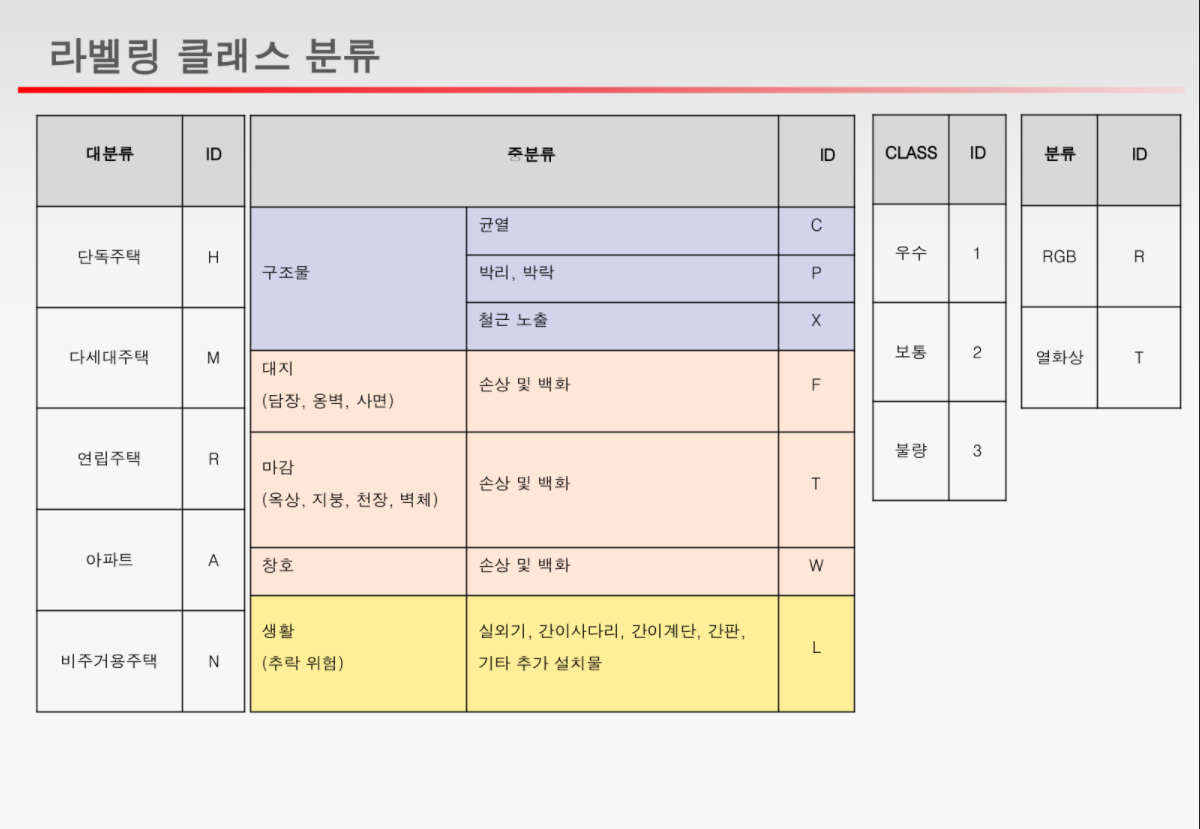


In [6]:
import matplotlib.pyplot as plt
import os 
import json
import shutil

image_id_name_mapping = {}

image_id = 0
j = 0

korean_english_mapping = {"단독주택": "house", "다세대주택":"walkup", "연립주택":"villa", "아파트":"apartment", "비주거용주택":"N/A", "구조물(균열)":"structure(crack)", \
                         "구조물(박리)":"structure(peeling)", "철근노출":"exposed_rebar", "대지(손상및백화)":"building(damaged/whitened)", "마감(손상및백화)":"finishing(damaged/whitened)",\
                         "창호(손상및백화)":"window(damaged/whitened)", "생활":"activity"}
super_categories_mapping = {"H":"단독주택", "M":"다세대주택", "R": "연립주택", "A":"아파트", "N":"비주거용주택"}
inter_categories_mapping = {"C":"구조물(균열)", "P":"구조물(박리)", "X": "철근노출", "F":"대지(손상및백화)", "T":"마감(손상및백화)", \
                            "W": "창호(손상및백화)", "L":"생활"}
class_id_mapping = {"1":"우수", "2":"보통", "3":"불량"}

for root, dirs,files in os.walk("C:/Users/david/Desktop/collated_data"):
    for file in files:
        if file.endswith(".json"):
            with open(root+"/"+file, "r", encoding='utf-8') as f:
                _, super_category, category, num, _, _= file.split("_")
                
                json_loaded = json.load(f)['Learning data info']
                json_data_id = json_loaded['Json data ID']
                type_image = json_data_id.split("_")[4]

                if type_image != "T":
                    if json_data_id not in image_id_name_mapping:
                        image_id += 1
                        image_id_name_mapping[json_data_id] = image_id

                    COCO_Builder.add_image(file_name=file.replace(".json", ".jpg"), height=1920, width=1080, date_captured="", _id=image_id_name_mapping[json_data_id])

                    for annotation in json_loaded['Annotations']:
                        try:
                            COCO_Builder.add_category(supercategory = super_categories_mapping[super_category], _id  = annotation['Class ID'], name=inter_categories_mapping[category])
                        
                        except:
                            pass
                        
                        Type = annotation['Type']
                        if Type == "polygon":
                            segmentation = annotation[Type]
                            class_id = annotation['Class ID']
                            COCO_Builder.add_annotation(segmentation, 0, 0, image_id, [], class_id, j)
                            j += 1

                        if Type == "bbox":
                            bbox = annotation[Type]
                            class_id = annotation['Class ID']
                            COCO_Builder.add_annotation([], 0, 0, image_id, bbox, class_id, j)
                            j += 1

In [7]:
COCO_Builder.build_json("C:/Users/david/Desktop/test.json")

In [8]:
test =json.load(open("C:/Users/david/Desktop/test.json", "r", encoding="utf-8"))

In [9]:
len(test['images'])

486

# visualize

다세대주택_2_대지(손상및백화)


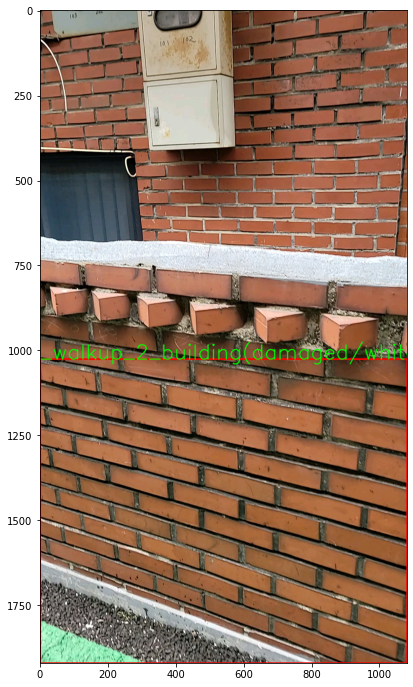

In [12]:
import cv2

plt.figure(1, figsize=(12, 12))
for i, img in enumerate(test['images']):
    file_name = img['file_name']
    if i == 150: #Change the number
        read_img=plt.imread("C:/Users/david/Desktop/collated_data/"+file_name)
        for i, ant in enumerate(test['annotations']):
            if ant['image_id'] == img['id']:
                #refer to same image
                if ant['segmentation'] != []:
                    segmentation = ant['segmentation']
                    temp = np.array(segmentation).reshape(len(segmentation)//2, 2)
                    cv2.polylines(read_img, [temp], True, (255, 0, 0), 2)
                    
                else:
                    x1, y1, x2, y2 = ant['bbox']
                    cv2.rectangle(read_img, (x1, y1), (x2, y2), (255, 0, 0), 3)
                
                
                temp_str = ""
                for temp in test['categories'][i].values():
                    if not temp.isnumeric():
                        temp_str = temp_str +"_"+ korean_english_mapping[temp] 
                    else:
                        temp_str = temp_str +"_"+ temp
                        
                cv2.putText(read_img, temp_str, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)
                print("_".join(test['categories'][i].values()))
        plt.imshow(read_img)